## Import Data ##

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pillow_avif
import seaborn_image as isns
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
import os

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [27]:
image_path = []
labels = []

dir_path = os.getcwd()

for i in listdir_nohidden(f"{dir_path}/Car-Bike-Dataset"):
    for label in listdir_nohidden(f"{dir_path}/Car-Bike-Dataset/{i}"):
        for image in listdir_nohidden(f"{dir_path}/Car-Bike-Dataset/{i}"):
            image_path.append(f"{dir_path}/Car-Bike-Dataset/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

image_path labels
0     /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...    Car
1     /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...    Car
2     /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...    Car
3     /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...    Car
4     /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...    Car
...                                                 ...    ...
3995  /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...   Bike
3996  /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...   Bike
3997  /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...   Bike
3998  /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...   Bike
3999  /Users/jay/Jupyter Projects/CarvsBike/Car-Bike...   Bike

[4000 rows x 2 columns]

## Statistical Modeling ##

Shape:  (4000, 2)

Counts:
 labels
Car     2000
Bike    2000
Name: count, dtype: int64



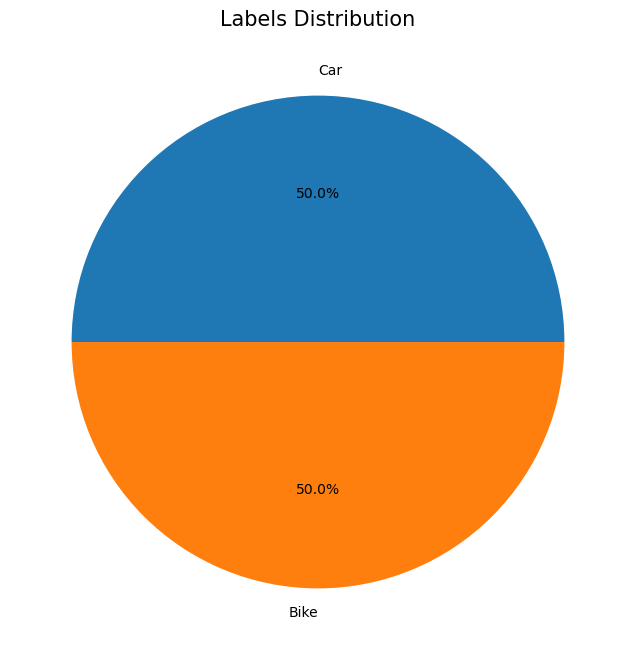

In [29]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

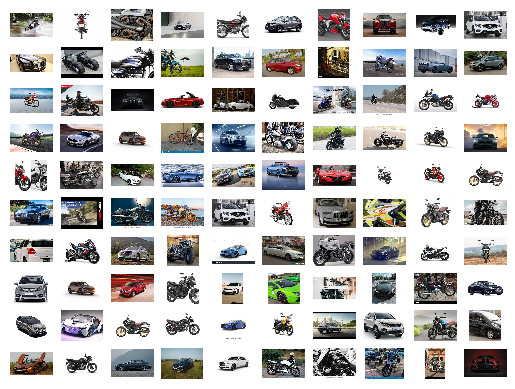

In [31]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()


Description for Image 1:

No. of Obs. : 50625
Min. Value : 0
Max. Value : 255
Mean : 189.3939950617284
Variance : 8085.791390931154
Skewness : -0.8638395329043138

Description for Image 2:

No. of Obs. : 50250
Min. Value : 0
Max. Value : 255
Mean : 69.70007960199005
Variance : 5325.540944092053
Skewness : 1.3571689933888096

Description for Image 3:

No. of Obs. : 50325
Min. Value : 0
Max. Value : 255
Mean : 141.37094883258817
Variance : 5019.375787441246
Skewness : -0.1592660209223346

Description for Image 4:

No. of Obs. : 50336
Min. Value : 0
Max. Value : 255
Mean : 116.49358312142402
Variance : 4054.9064056292486
Skewness : -0.2425947880001428

Description for Image 5:

No. of Obs. : 10000
Min. Value : 0
Max. Value : 255
Mean : 170.2791
Variance : 7543.704973687368
Skewness : -0.5420524920374626


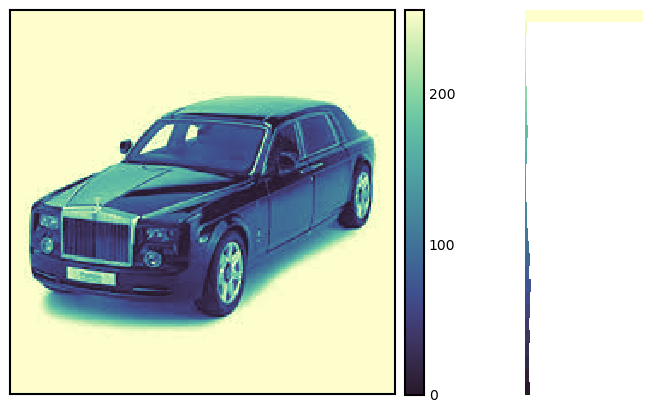

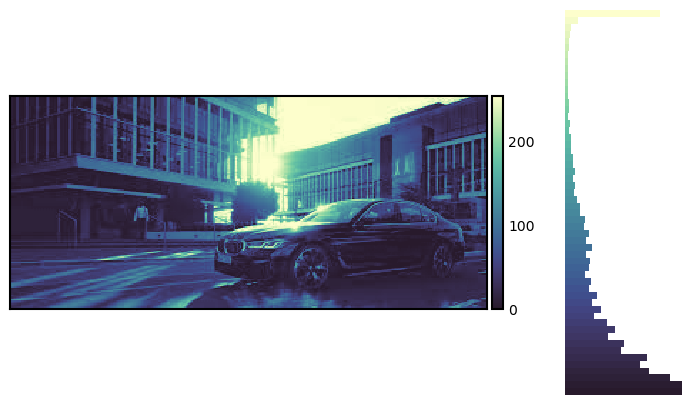

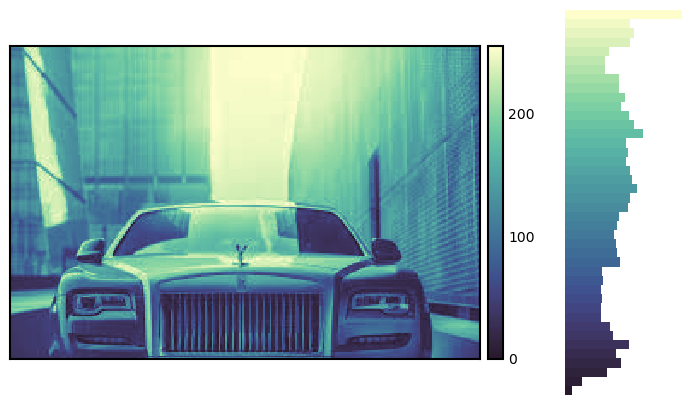

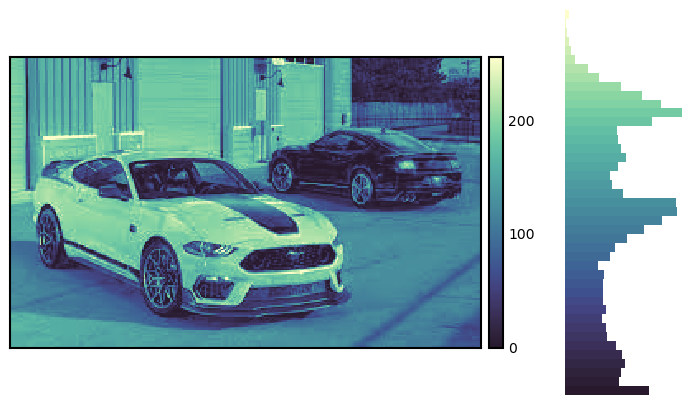

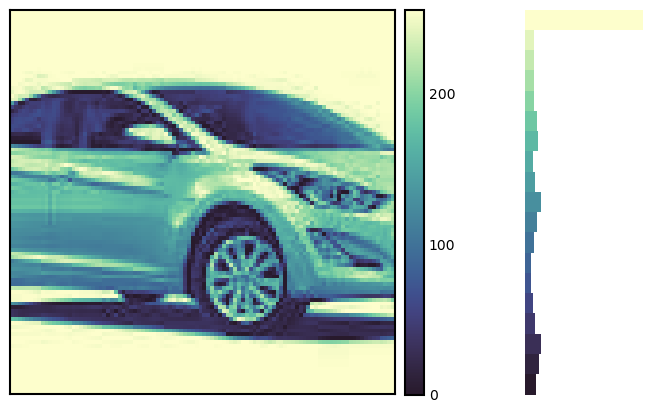

In [32]:
for i in range(5):
    pol = plt.imread(df.iloc[i, 0])[:, :, 0]
    print(f"\nDescription for Image {i+1}:\n")
    f = isns.imghist(pol, describe=True)
    print("="*50)

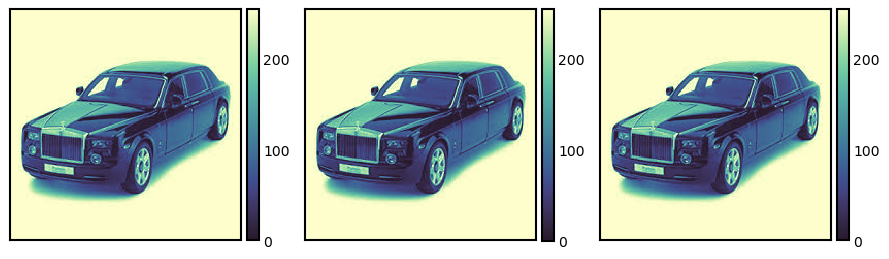

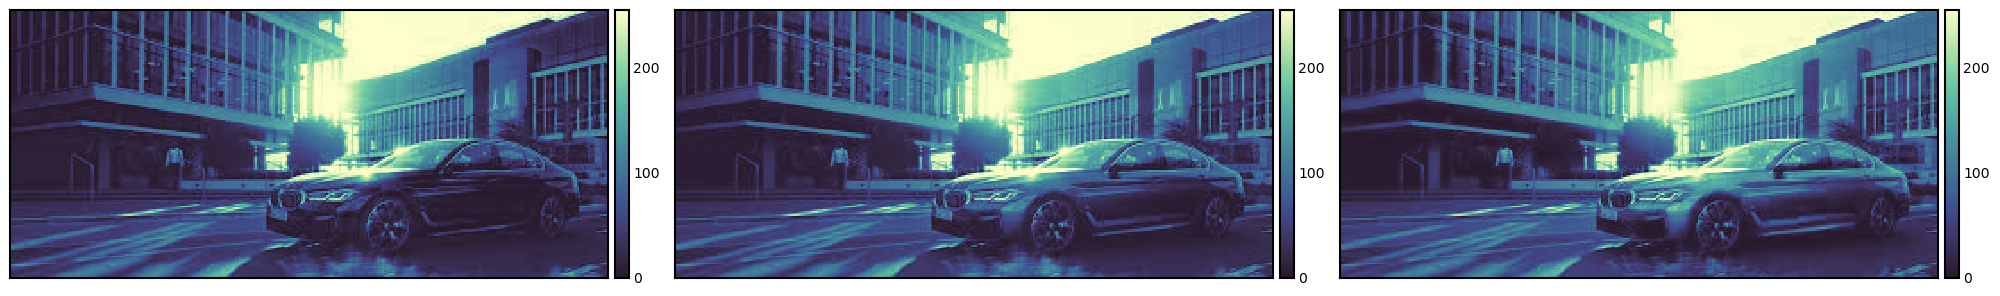

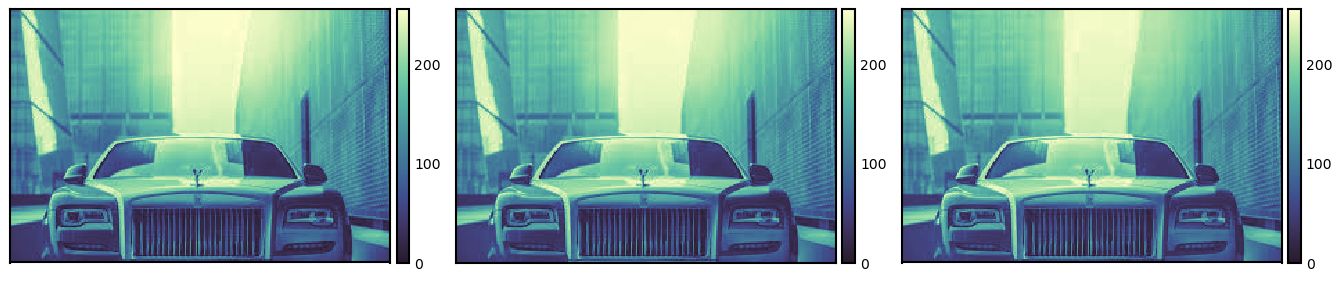

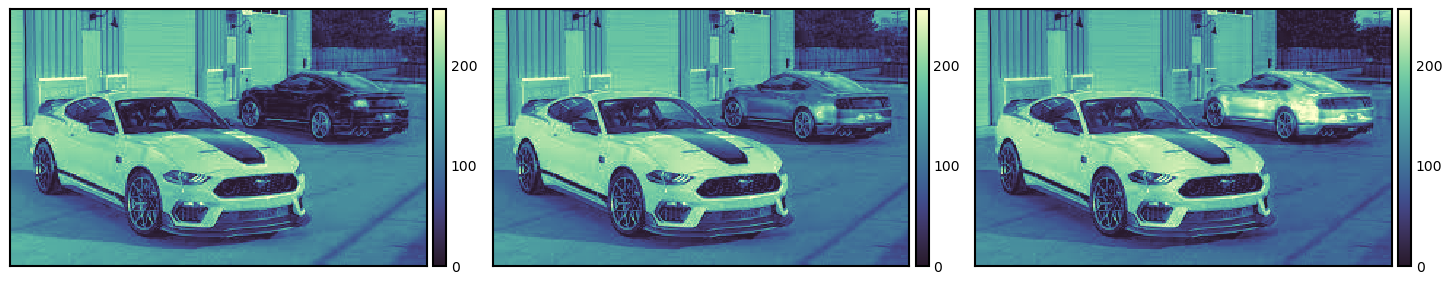

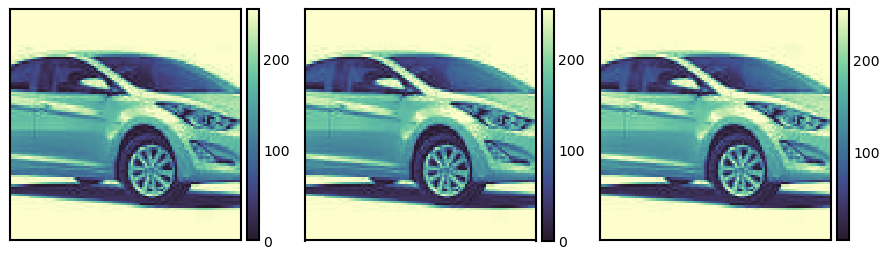

In [33]:
for i in range(5):
    ims = plt.imread(df.iloc[i, 0])
    grid = isns.ImageGrid(ims)

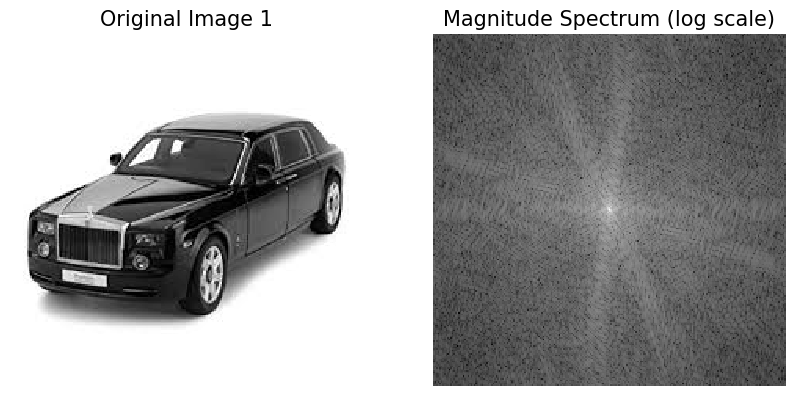

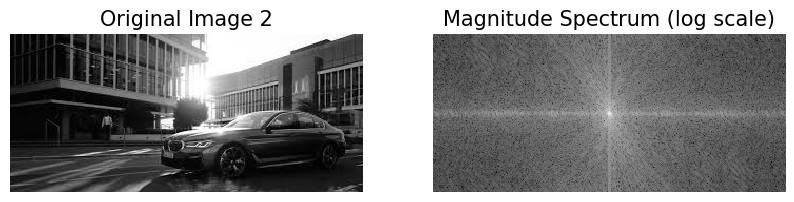

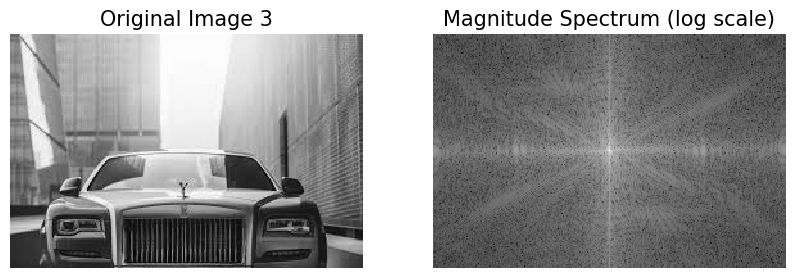

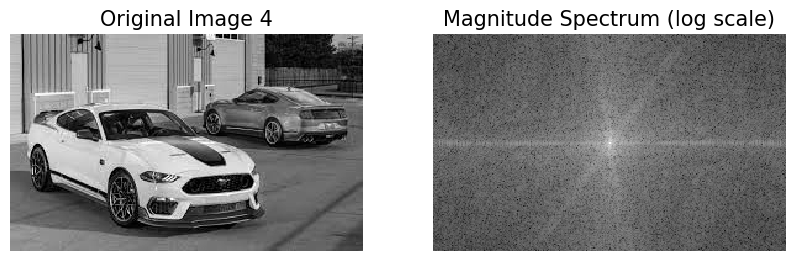

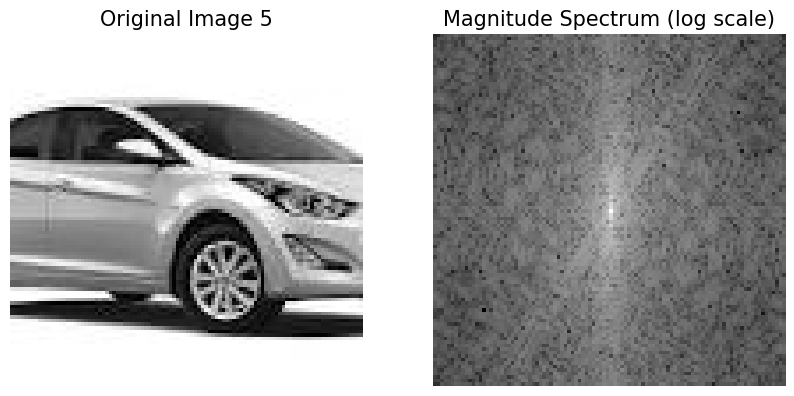

In [35]:
for i in range(5):
    img_data = plt.imread(df.iloc[i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(img_data)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log, cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

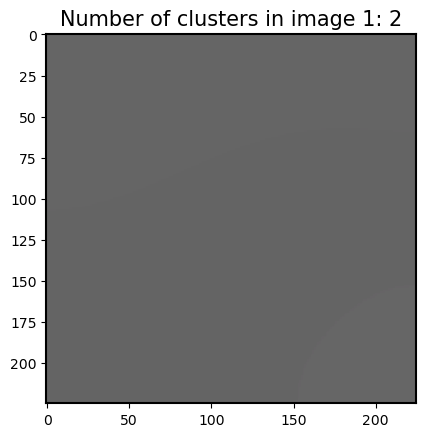

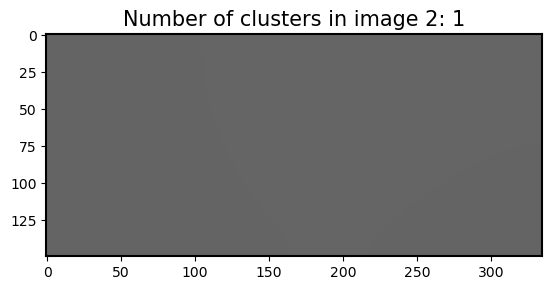

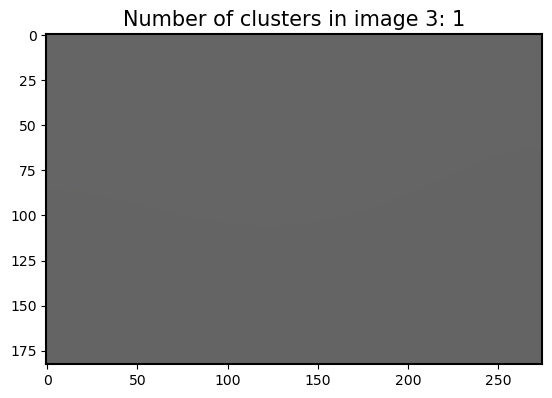

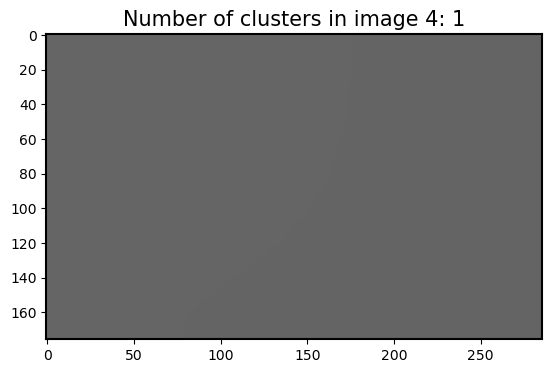

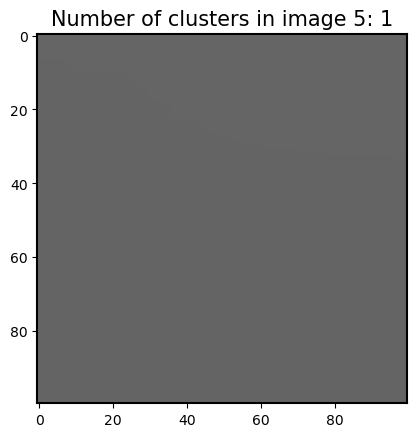

In [37]:
from scipy import ndimage

for i in range(5):
    plt.figure()
    
    im = Image.open(df.iloc[i, 0])
    im2 = ndimage.gaussian_filter(im, sigma=np.std(np.array(im)))
    plt.imshow(im2);
    mask = im2 > im2.mean()
    label_im, nb_labels = ndimage.label(mask)
    plt.title(f"Number of clusters in image {i+1}: {nb_labels}")
    brightness = 100
    plt.imshow(label_im+brightness);

## Training Model ##

In [41]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(2800, 2)
(600, 2)
(600, 2)


In [76]:
class RandomCrop:
    def __init__(self, crop_probability=0.15, crop_percent_range=(0.7, 0.95)):
        self.crop_probability = crop_probability
        self.crop_percent_range = crop_percent_range

    def __call__(self, image):
        if random.random() > self.crop_probability:
            return image

        if isinstance(image, Image.Image):
            image = np.array(image)

        height, width = image.shape[:2]

        crop_percent = random.uniform(*self.crop_percent_range)
        new_width = int(width * crop_percent)
        new_height = int(height * crop_percent)

        if new_width == width or new_height == height:
            return Image.fromarray(image)

        left = random.randint(0, width - new_width)
        top = random.randint(0, height - new_height)

        cropped = image[top:top + new_height, left:left + new_width]

        if cropped.dtype <= np.uint8:
            cropped = np.clip(cropped * 255, 0, 255).astype(np.uint8)
        else:
            cropped = cropped.astype(np.uint8)

        return Image.fromarray(cropped)

In [78]:
class NumpyOperations:
    def __init__(self, augment_probability=0.15, apply_LinearAl_ops = False):
        self.augment_probability = augment_probability
        self.apply_LinearAl_ops = apply_LinearAl_ops

    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = image_np / 255
        
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np, k=3)
            
        if random.random() < self.augment_probability:
            image_np = np.flip(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.fliplr(image_np)
                        
        if random.random() < self.augment_probability:
            image_np = np.flipud(image_np)
                        
        if random.random() < self.augment_probability:
            brightness = random.randrange(10, 100)
            image_np = image_np.astype(np.uint16) + brightness
        
        if self.apply_LinearAl_ops:
            image_np = np.transpose(image_np, (1, 0, 2))
        
        image_np = np.clip(image_np, 0, 255)
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
        
        return image_pil

In [80]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    RandomCrop(),
    transforms.Resize([128, 128]),
    NumpyOperations(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(torch.float)
])

In [82]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_probability=0.15):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.augment_probability = augment_probability
        self.operation_transform = NumpyOperations(augment_probability, apply_LinearAl_ops=False) #Can toggle the linal ops
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)
        self.original_len = len(dataframe)

    def __len__(self):
        return 2 * self.original_len

    def __getitem__(self, idx):
        is_augmented = idx >= self.original_len
        real_idx = idx % self.original_len

        img_path = self.dataframe.iloc[real_idx, 0]
        label = self.labels[real_idx]
        image = Image.open(img_path).convert("RGB")

        if is_augmented:
            image = self.operation_transform(image)

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [83]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

print("New Train Dataset Size:", len(train_dataset))
print("New Validation Dataset Size:", len(val_dataset))
print("New Test Dataset Size:", len(test_dataset))

New Train Dataset Size: 5600
New Validation Dataset Size: 1200
New Test Dataset Size: 1200


In [84]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [85]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [90]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [91]:
model = Net().to(device)

In [92]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            258
Total params: 4,287,938
Trainable params: 4,287,938
Non-trainable params: 0

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [94]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/10 
    Training Loss: 0.2147 
    Training Accuracy: 63.6071 
    Validation Loss: 0.0392 
    Validation Accuracy: 72.5
Epoch no. 2/10 
    Training Loss: 0.1714 
    Training Accuracy: 73.5179 
    Validation Loss: 0.0349 
    Validation Accuracy: 73.9167
Epoch no. 3/10 
    Training Loss: 0.1508 
    Training Accuracy: 77.0 
    Validation Loss: 0.0325 
    Validation Accuracy: 75.8333
Epoch no. 4/10 
    Training Loss: 0.1389 
    Training Accuracy: 78.75 
    Validation Loss: 0.0286 
    Validation Accuracy: 80.0833
Epoch no. 5/10 
    Training Loss: 0.1291 
    Training Accuracy: 80.0714 
    Validation Loss: 0.0287 
    Validation Accuracy: 78.75
Epoch no. 6/10 
    Training Loss: 0.1192 
    Training Accuracy: 81.3036 
    Validation Loss: 0.0327 
    Validation Accuracy: 77.5
Epoch no. 7/10 
    Training Loss: 0.1162 
    Training Accuracy: 81.7857 
    Validation Loss: 0.028 
    Validation Accuracy: 79.9167
Epoch no. 8/10 
    Training Loss: 0.1163 
    Training

In [95]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 80.75 
Loss: 0.0272


## Post-Training Analysis ##

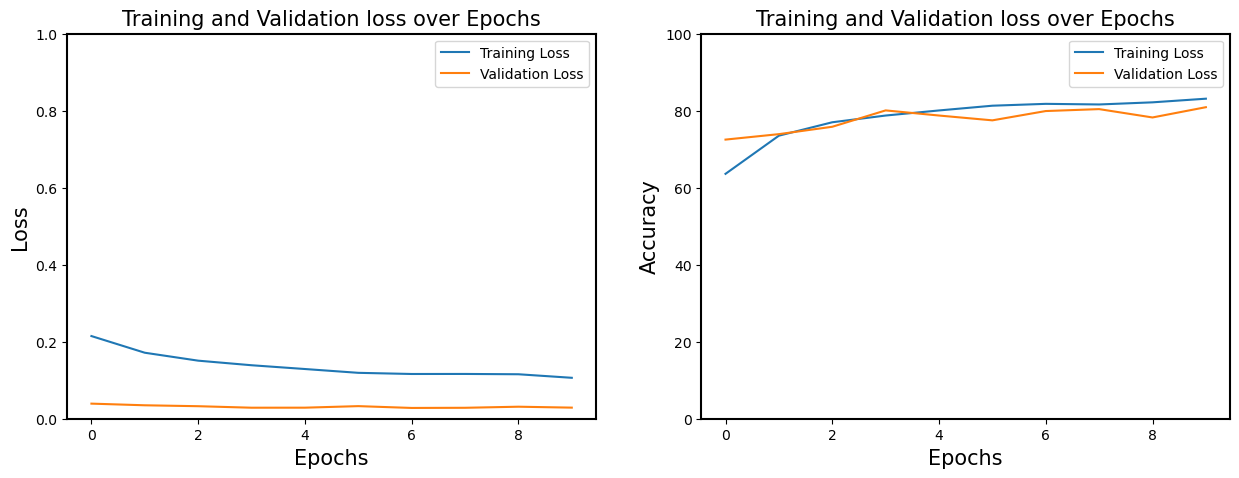

In [104]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [105]:
torch.save(model.state_dict(), "CarvsBike.pth")

In [106]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("CarvsBike.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

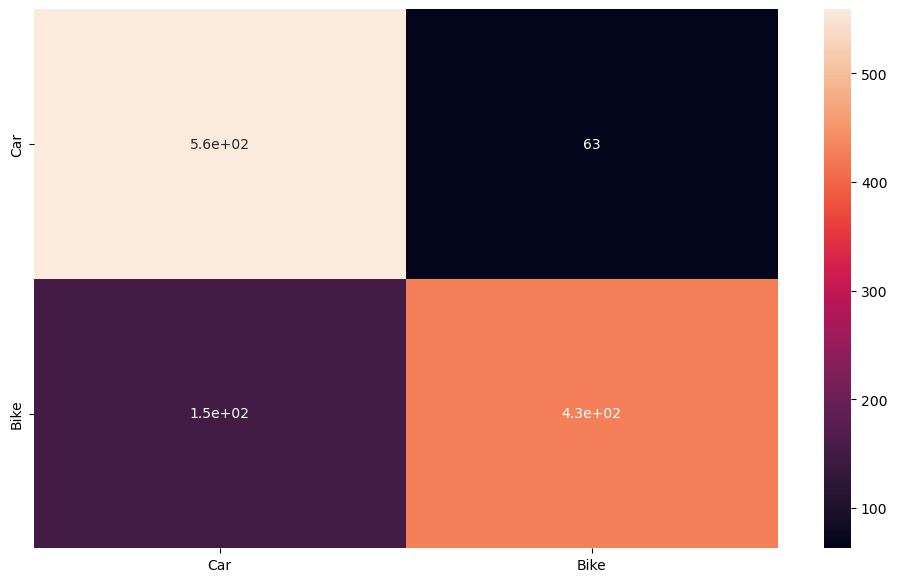

In [107]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = loaded_model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = df["labels"].unique()

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True);

In [108]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])[0]


def predict_image_prob(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    model_prediction_prob = F.sigmoid(loaded_model(image.unsqueeze(0))).cpu().detach().numpy()
    return model_prediction_prob[0]

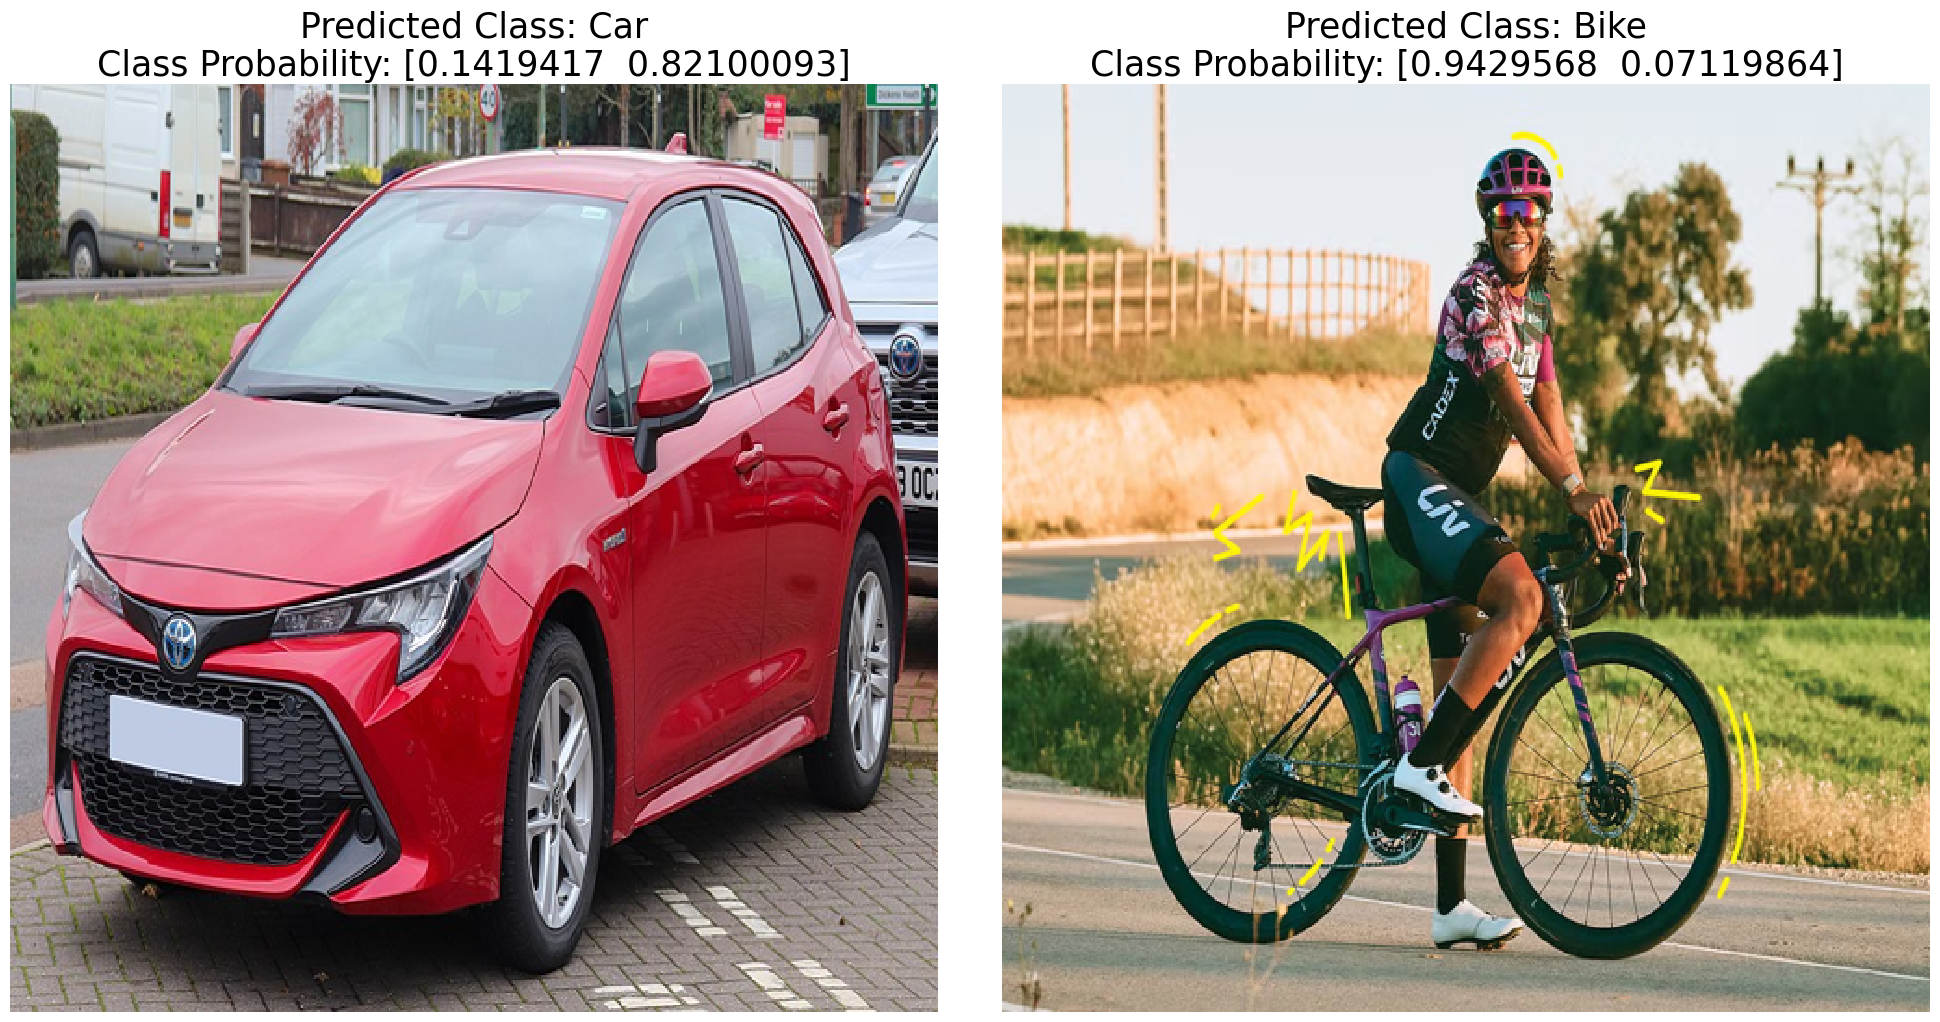

In [109]:
paths = [f"{dir_path}/Car.jpg",
         f"{dir_path}/Bike.avif"]


def prediction(x):
    fig, axes = plt.subplots(1, x, figsize=(10*x, 10))

    if x == 1:
        axes = [axes]
    
    for i in range(x):
        image = Image.open(paths[i]).convert("RGB").resize((500, 500))
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted Class: {predict_image(paths[i])}\nClass Probability: {predict_image_prob(paths[i])}", fontsize=25)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()
 

prediction(len(paths))

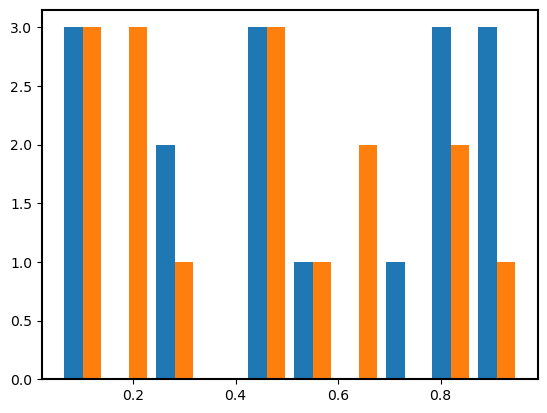

In [171]:
probs = F.sigmoid(outputs)
plt.hist(np.array(probs.cpu()))
plt.show()